In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import mpl_toolkits.axes_grid1
import matplotlib.widgets
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
from skyfield.api import Loader
import matplotlib.animation as animation
import tensorflow as tf
import kessler
from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler
import glob
from PIL import Image

In [2]:
# https://stackoverflow.com/questions/46325447/animated-interactive-plot-using-matplotlib
class Player(FuncAnimation):
    def __init__(self, fig, func, frames=None, init_func=None, fargs=None,
                 save_count=None, mini=0, maxi=100, pos=(0.125, 0.92), **kwargs):
        self.i = 0
        self.min=mini
        self.max=maxi
        self.runs = True
        self.forwards = True
        self.fig = fig
        self.func = func
        self.setup(pos)
        FuncAnimation.__init__(self,self.fig, self.update, frames=self.play(), interval=10,
                                           init_func=init_func, fargs=fargs,
                                           save_count=save_count, **kwargs )    

    def play(self):
        while self.runs:
            self.i = self.i+self.forwards-(not self.forwards)
            if self.i > self.min and self.i < self.max:
                yield self.i
            else:
                self.stop()
                yield self.i

    def start(self):
        self.runs=True
        self.event_source.start()

    def stop(self, event=None):
        self.runs = False
        self.event_source.stop()

    def forward(self, event=None):
        self.forwards = True
        self.start()
    def backward(self, event=None):
        self.forwards = False
        self.start()
    def oneforward(self, event=None):
        self.forwards = True
        self.onestep()
    def onebackward(self, event=None):
        self.forwards = False
        self.onestep()

    def onestep(self):
        if self.i > self.min and self.i < self.max:
            self.i = self.i+self.forwards-(not self.forwards)
        elif self.i == self.min and self.forwards:
            self.i+=1
        elif self.i == self.max and not self.forwards:
            self.i-=1
        self.func(self.i)
        self.slider.set_val(self.i)
        self.fig.canvas.draw_idle()

    def setup(self, pos):
        playerax = self.fig.add_axes([pos[0],pos[1], 0.64, 0.04])
        divider = mpl_toolkits.axes_grid1.make_axes_locatable(playerax)
        bax = divider.append_axes("right", size="80%", pad=0.05)
        sax = divider.append_axes("right", size="80%", pad=0.05)
        fax = divider.append_axes("right", size="80%", pad=0.05)
        ofax = divider.append_axes("right", size="100%", pad=0.05)
        sliderax = divider.append_axes("right", size="500%", pad=0.07)
        self.button_oneback = matplotlib.widgets.Button(playerax, label='$\u29CF$')
        self.button_back = matplotlib.widgets.Button(bax, label='$\u25C0$')
        self.button_stop = matplotlib.widgets.Button(sax, label='$\u25A0$')
        self.button_forward = matplotlib.widgets.Button(fax, label='$\u25B6$')
        self.button_oneforward = matplotlib.widgets.Button(ofax, label='$\u29D0$')
        self.button_oneback.on_clicked(self.onebackward)
        self.button_back.on_clicked(self.backward)
        self.button_stop.on_clicked(self.stop)
        self.button_forward.on_clicked(self.forward)
        self.button_oneforward.on_clicked(self.oneforward)
        self.slider = matplotlib.widgets.Slider(sliderax, '', 
                                                self.min, self.max, valinit=self.i)
        self.slider.on_changed(self.set_pos)

    def set_pos(self,i):
        self.i = int(self.slider.val)
        self.func(self.i)

    def update(self,i):
        self.slider.set_val(i)

### Import satelite and debris data

In [3]:
# URL of the TLE data
satellites_urls = ["http://celestrak.org/NORAD/elements/gp.php?GROUP=weather&FORMAT=tle",
                  "http://celestrak.org/NORAD/elements/gp.php?GROUP=noaa&FORMAT=tle"]
debris_urls = ["http://celestrak.org/NORAD/elements/gp.php?GROUP=cosmos-2251-debris&FORMAT=tle",
              "http://celestrak.org/NORAD/elements/gp.php?GROUP=iridium-33-debris&FORMAT=tle",
              ]

# Load TLE data

load = Loader('./')

satellites = []
debris = []
for s_url in satellites_urls:
    satellites.extend(load.tle_file(url=s_url,filename='satellites.php'))
print('Loaded', len(satellites), 'satellites')
for d_url in debris_urls:
    debris.extend(load.tle_file(url=d_url,filename='debris.php'))
print('Loaded', len(debris), 'debris')

Loaded 94 satellites
Loaded 1708 debris


In [4]:
# Set Earth location
ts = load.timescale()
t = ts.now()
print(satellites[0])
s0_geocentric = satellites[0].at(t)
dx, dy, dz = s0_geocentric.velocity.km_per_s
print(f"Velocity of {satellites[0].name}: ({dx}, {dy}, {dz}) km/s")

NOAA 15 catalog #25338 epoch 2023-07-30 02:06:46 UTC
Velocity of NOAA 15: (3.427808748808152, 6.558718814361922, 0.8678408704161734) km/s


### Train ML model for risk predictions

In [5]:
model = tf.keras.models.load_model("kessler_model")

In [6]:
target = np.array([s0_geocentric.position.km,s0_geocentric.velocity.km_per_s]).flatten()
# print(target)
x_test = []
for deb in debris:
    x,y,z = deb.at(t).position.km
    dx,dy,dz = deb.at(t).velocity.km_per_s
    rtn, _ = kessler.util.from_cartesian_to_rtn(np.array([[x,y,z],[dx,dy,dz]]))
    x_test.append(rtn.flatten())
x_test = np.array(x_test)
print(x_test.shape)

risks = model.predict(x_test - target)

(1708, 6)
54/54 [==============================] - 0s 365us/step


2023-08-01 11:03:32.634427: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


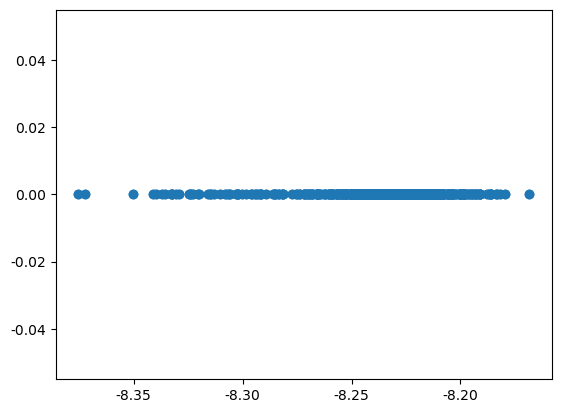

In [7]:
plt.figure()
plt.scatter(risks,np.zeros(risks.shape))

In [8]:
risks[0,0]

-8.24109

### Visualisation of collision model based on risk output from ML model

(1708, 6)
54/54 [==============================] - 0s 372us/step
0.0339126
(1708, 6)
54/54 [==============================] - 0s 345us/step
0.03391274
(1708, 6)
54/54 [==============================] - 0s 331us/step
0.03391288
(1708, 6)
54/54 [==============================] - 0s 320us/step
0.033913016
(1708, 6)
54/54 [==============================] - 0s 321us/step
0.033913136
(1708, 6)
54/54 [==============================] - 0s 336us/step
0.033913262
(1708, 6)
54/54 [==============================] - 0s 331us/step
0.033913374
(1708, 6)
54/54 [==============================] - 0s 320us/step
0.033913482
(1708, 6)
54/54 [==============================] - 0s 325us/step
0.033913586
(1708, 6)
54/54 [==============================] - 0s 321us/step
0.033913683


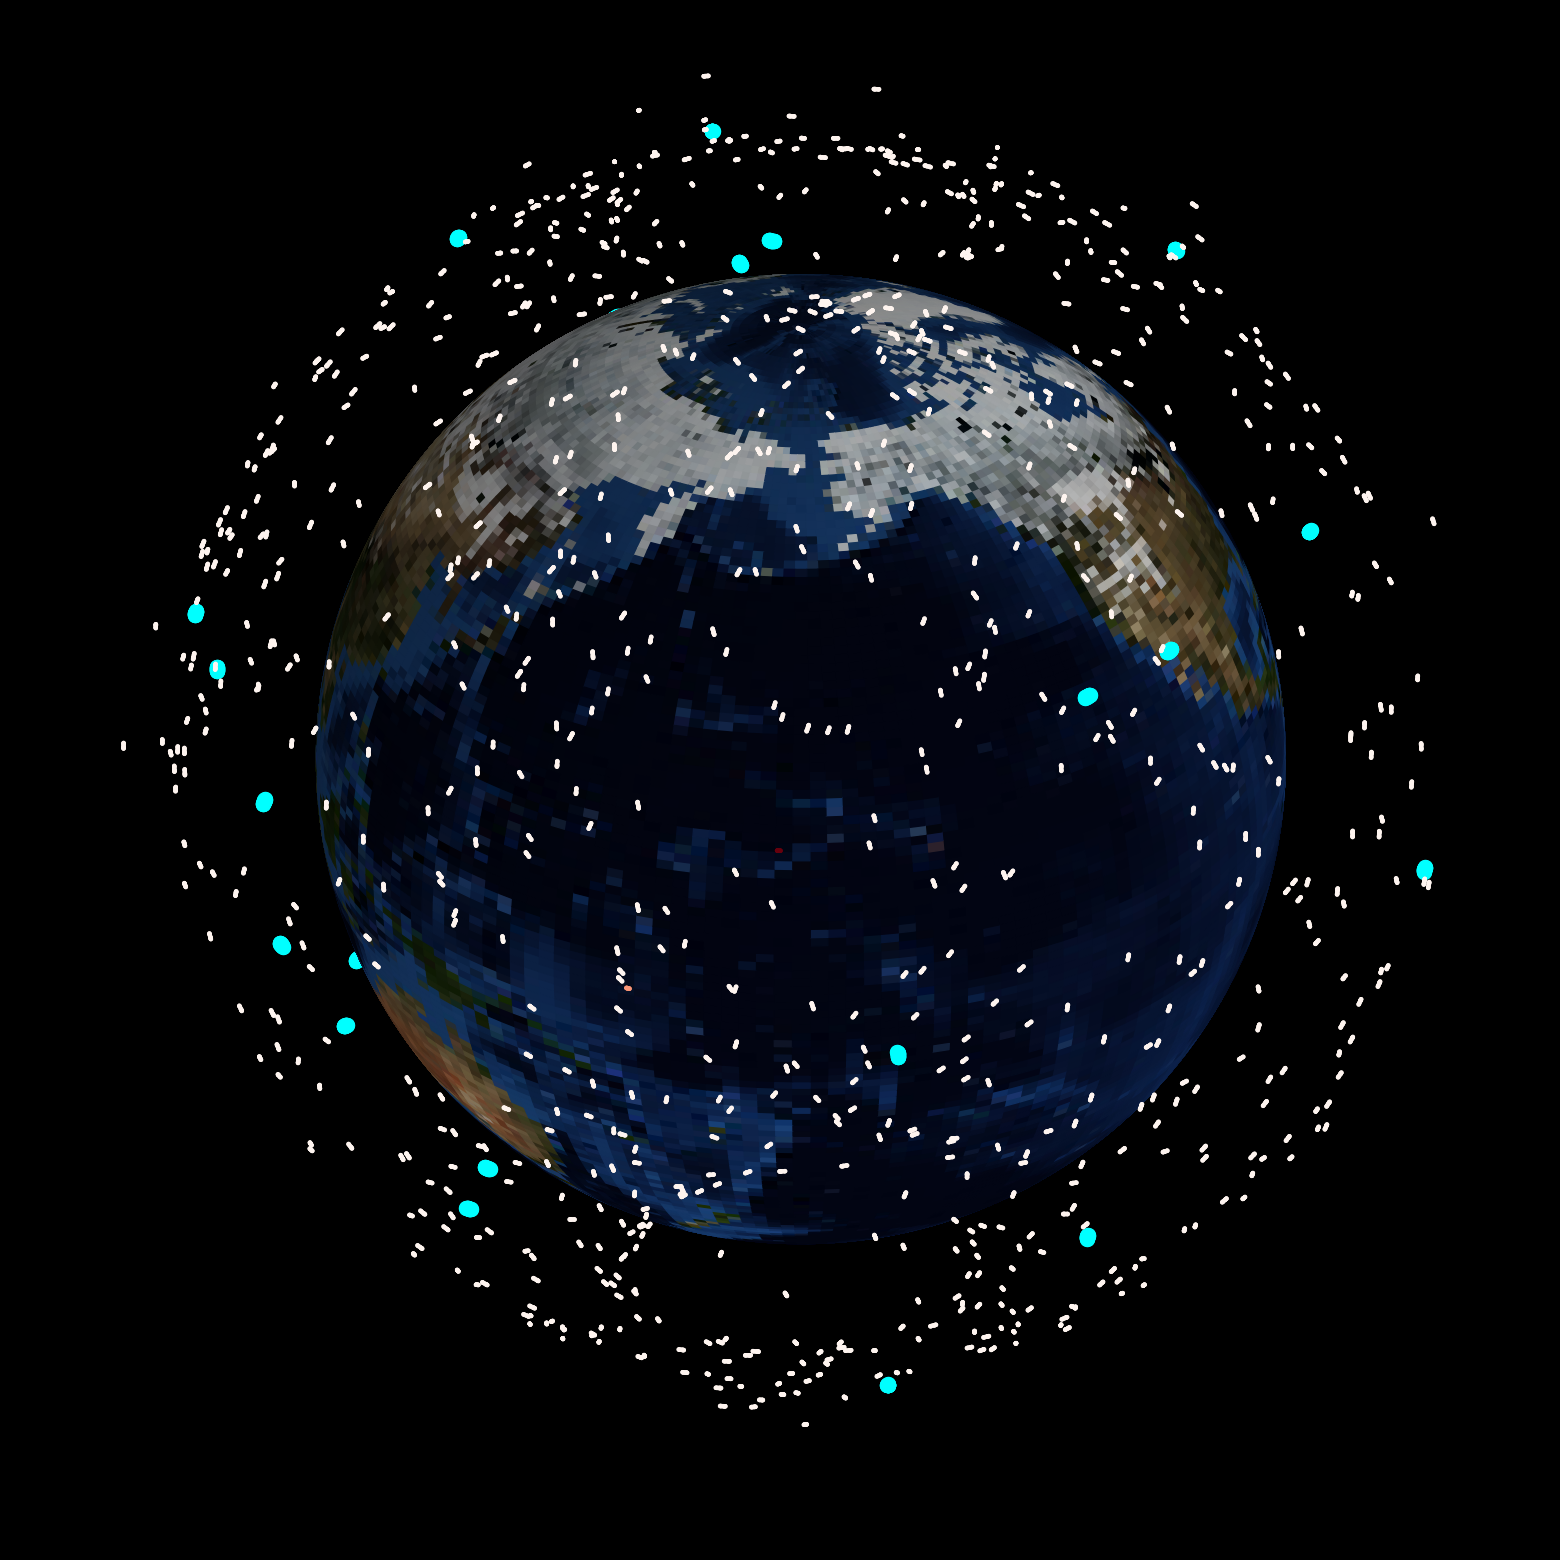

In [10]:
# plt.ioff()
counter = 0
c = []
# Set Earth location
ts = load.timescale()
t = ts.utc(2023,3,10,12,1,range(10))

# Prepare figure
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection="3d")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_axis_off() 
fig.set_facecolor('black')
ax.set_facecolor('black')

for i in t:
    # https://stackoverflow.com/questions/53074908/map-an-image-onto-a-sphere-and-plot-3d-trajectories
    image_file = 'blue_marble.jpg'
    img = plt.imread(image_file)

    # define a grid matching the map size, subsample along with pixels
    theta = np.linspace(0, np.pi, img.shape[0])
    phi = np.linspace(0, 2*np.pi, img.shape[1])

    count = 180 # keep 180 points along theta and phi
    theta_inds = np.linspace(0, img.shape[0] - 1, count).round().astype(int)
    phi_inds = np.linspace(0, img.shape[1] - 1, count).round().astype(int)
    theta = theta[theta_inds]
    phi = phi[phi_inds]
    img = img[np.ix_(theta_inds, phi_inds)]

    theta,phi = np.meshgrid(theta, phi)
    # R = 6.378e+3
    R = 5.5e+3

    # sphere
    x = R * np.sin(theta) * np.cos(phi)
    y = R * np.sin(theta) * np.sin(phi)
    z = R * np.cos(theta)
    ax.plot_surface(x.T, y.T, z.T, facecolors=img/255, cstride=1, rstride=1) # we've already pruned ourselves

    # Plot each satellite
    deb_x = []
    deb_y = []
    deb_z = []

    check = True
    for sat in satellites:
        geocentric = sat.at(i)
        x, y, z = geocentric.position.km
        if check:
            ax.scatter(x, y, z, c='springgreen',s=50)
            check = False
        if not check:
            ax.scatter(x, y, z, c='cyan',s=100)

    # Plot each debris
    for deb in debris:
        geocentric = deb.at(i)
        x, y, z = geocentric.position.km
        deb_x.append(x)
        deb_y.append(y)
        deb_z.append(z)
        # ax.scatter(x, y, z, c=c, cmap='seismic',s=5)

    target = np.array([s0_geocentric.position.km,s0_geocentric.velocity.km_per_s]).flatten()
    # print(target)
    x_test = []
    for deb in debris:
        x1,y1,z1 = deb.at(i).position.km
        dx1,dy1,dz1 = deb.at(i).velocity.km_per_s
        rtn, _ = kessler.util.from_cartesian_to_rtn(np.array([[x1,y1,z1],[dx1,dy1,dz1]]))
        x_test.append(rtn.flatten())
    x_test = np.array(x_test)
    print(x_test.shape)

    risks = model.predict(x_test - target)

    mms = MinMaxScaler()
    mms.fit(risks)
    risks = mms.fit_transform(risks)
    print(np.std(risks))

    sc = ax.scatter(np.array(deb_x), np.array(deb_y), np.array(deb_z), c=risks, cmap='Reds', s=5, vmin=0.993, vmax=1)
    
    # ax.scatter(np.array(deb_x)[(risks>0.995).flatten()], np.array(deb_y)[(risks>0.995).flatten()],
    #            np.array(deb_z)[(risks>0.995).flatten()], c=risks[(risks>0.995).flatten()], cmap='Reds', s=50, vmin=0.995, vmax=1)

    # Display the plot
    lim_ = 5000
    ax.set_xlim(-lim_,lim_)
    ax.set_ylim(-lim_,lim_)
    ax.set_zlim(-lim_,lim_)
    ax.set_aspect("equal")

    # plt.colorbar(sc)
    # plt.show()

    if counter<360:
        ax.view_init(azim=counter)

    plt.savefig(r'Outputs/'+str(counter)+'.png');
    counter = counter + 1

In [11]:
# Create the frames
frames = []
imgs = glob.glob(r"Outputs/*.png")

for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save('Testing/Collision Risk.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=200, loop=0)

### Interactive visualisation for one timeframe

In [12]:
# for creating a responsive plot
%matplotlib widget

(1708, 6)
54/54 [==============================] - 0s 364us/step
0.0339126


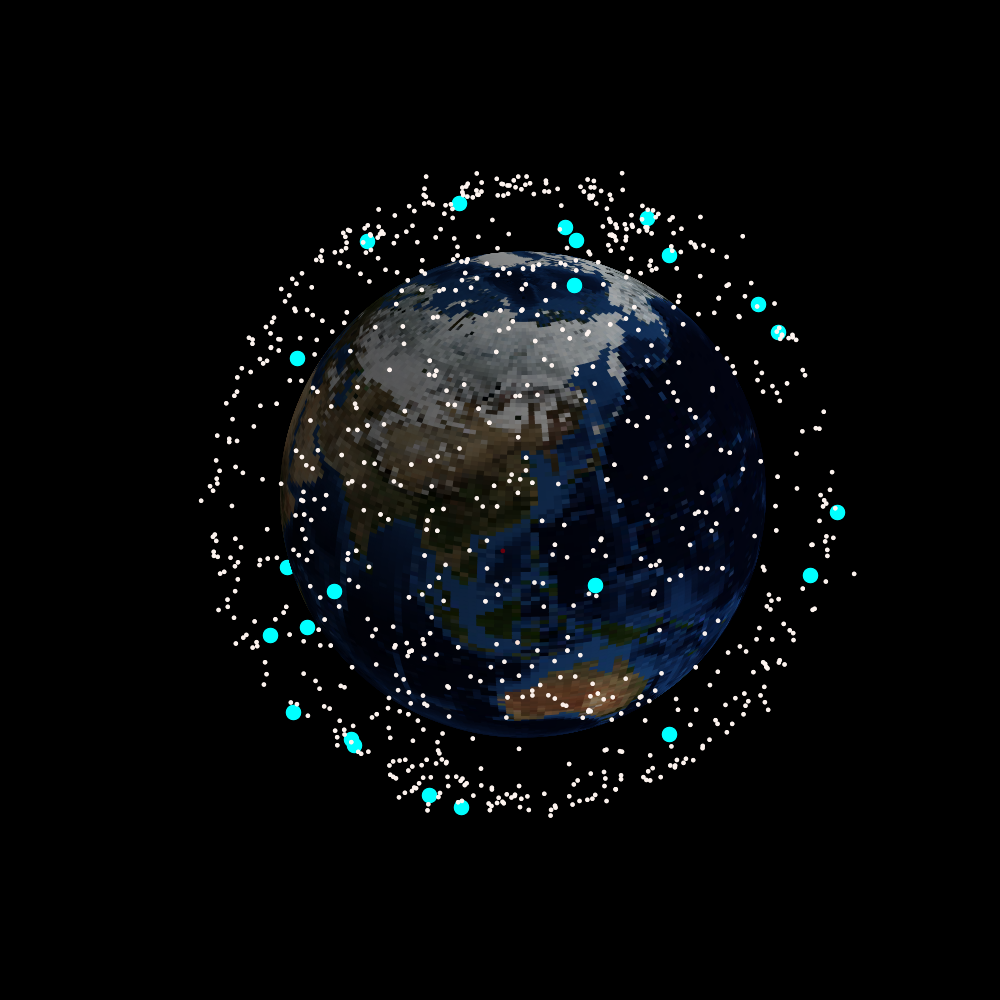

In [13]:
# plt.ioff()
counter = 0
c = []
# Set Earth location
ts = load.timescale()
t = ts.utc(2023,3,10,12,1,range(1))

# Prepare figure
    
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection="3d")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_axis_off() 
fig.set_facecolor('black')
ax.set_facecolor('black')

for i in t:
    # https://stackoverflow.com/questions/53074908/map-an-image-onto-a-sphere-and-plot-3d-trajectories
    image_file = 'blue_marble.jpg'
    img = plt.imread(image_file)

    # define a grid matching the map size, subsample along with pixels
    theta = np.linspace(0, np.pi, img.shape[0])
    phi = np.linspace(0, 2*np.pi, img.shape[1])

    count = 180 # keep 180 points along theta and phi
    theta_inds = np.linspace(0, img.shape[0] - 1, count).round().astype(int)
    phi_inds = np.linspace(0, img.shape[1] - 1, count).round().astype(int)
    theta = theta[theta_inds]
    phi = phi[phi_inds]
    img = img[np.ix_(theta_inds, phi_inds)]

    theta,phi = np.meshgrid(theta, phi)
    # R = 6.378e+3
    R = 5.5e+3

    # sphere
    x = R * np.sin(theta) * np.cos(phi)
    y = R * np.sin(theta) * np.sin(phi)
    z = R * np.cos(theta)
    ax.plot_surface(x.T, y.T, z.T, facecolors=img/255, cstride=1, rstride=1) # we've already pruned ourselves

    # Plot each satellite
    deb_x = []
    deb_y = []
    deb_z = []

    check = True
    for sat in satellites:
        geocentric = sat.at(i)
        x, y, z = geocentric.position.km
        if check:
            ax.scatter(x, y, z, c='springgreen',s=50)
            check = False
        if not check:
            ax.scatter(x, y, z, c='cyan',s=100)

    # Plot each debris
    for deb in debris:
        geocentric = deb.at(i)
        x, y, z = geocentric.position.km
        deb_x.append(x)
        deb_y.append(y)
        deb_z.append(z)
        # ax.scatter(x, y, z, c=c, cmap='seismic',s=5)


    target = np.array([s0_geocentric.position.km,s0_geocentric.velocity.km_per_s]).flatten()
    # print(target)
    x_test = []
    for deb in debris:
        x1,y1,z1 = deb.at(i).position.km
        dx1,dy1,dz1 = deb.at(i).velocity.km_per_s
        rtn, _ = kessler.util.from_cartesian_to_rtn(np.array([[x1,y1,z1],[dx1,dy1,dz1]]))
        x_test.append(rtn.flatten())
    x_test = np.array(x_test)
    print(x_test.shape)

    risks = model.predict(x_test - target)

    mms = MinMaxScaler()
    mms.fit(risks)
    risks = mms.fit_transform(risks)
    print(np.std(risks))
    
    sc = ax.scatter(np.array(deb_x), np.array(deb_y), np.array(deb_z), c=risks, cmap='Reds', s=5, vmin=0.995, vmax=1)

    # Display the plot
    lim_ = 5000
    ax.set_xlim(-lim_,lim_)
    ax.set_ylim(-lim_,lim_)
    ax.set_zlim(-lim_,lim_)
    ax.set_aspect("equal")

    plt.show()